In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from torch.utils.data import Dataset
import scipy.io
import torch
import pytorch_lightning as pl
!pwd

sys.path.append('../')
from module.Pingfan_ver2_datamodule import MRIDataModule
from script.trainer import our_GRU, model_load_matcher

import pwd

from jinja2 import ModuleLoader
import pytorch_lightning as pl
import torch
import torchvision
from torch.utils.data import random_split, DataLoader, Dataset
import sys
import mat73
import h5py
from torch.nn import functional as F

from Bloch_decoder.utils.generate_RF_TR import generate_RF_TR

/mnt/ssd/jj/Research/cauMedical/lightning_bolts/script


# Variable setting

In [4]:
exp_id = 'SPLIT-274'
test_data_type = 'real'

# Data module

In [5]:
class MRIDataModule(pl.LightningDataModule):
    def __init__(
        self,
        batch_size: int = 1,
        num_workers=0,
        train_data_type="seq",  
        test_data_type="real", 
        subsamp=1,
        seq_jump=5,
        is_input_RF=0,
        need_T1T2_logscale=False,
        need_TETR_second=False,
        need_RF_degree=False,
    ):  # img_cnn, img_seq, seq
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_data_type = train_data_type
        self.testdata_type = test_data_type
        self.subsamp = subsamp
        self.seq_jump = seq_jump
        self.need_T1T2_logscale = need_T1T2_logscale
        self.need_TETR_second = need_TETR_second
        self.need_RF_degree = need_RF_degree
        self.datamodule = PingSeqDataset

        self.n_img_tr = 80 * 128 * 128
        self.n_img_te = 22 * 128 * 128

    def prepare_data(self):
        return

    def setup(self, stage=None):
        # Trainset
        if "seqTr" in self.train_data_type:
            self.trainset = self.datamodule(
                mode="train",
                is_split_range_T1T2=True,
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
        elif "seqAll" in self.train_data_type:
            self.trainset = self.datamodule(
                mode="none",
                is_split_range_T1T2=False,
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
        elif "phantomTr" in self.train_data_type:
            self.trainset = PingImgDataset_Phantom(mode="train")
        elif "phantomAll" in self.train_data_type:
            self.trainset = PingImgDataset_Phantom(mode="none")
        else:
            raise AssertionError("Check traindata_type")

        # Testset
        if "seqTe" in self.testdata_type:
            self.testset = self.datamodule(
                mode="test",
                is_split_range_T1T2=True,
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
        elif "phantomTe" in self.testdata_type:
            self.testset = PingImgDataset_Phantom(mode="test")
        elif "phantomAll" in self.testdata_type:
            self.testset = PingImgDataset_Phantom(mode="none")
        elif "real" in self.testdata_type:
            self.testset = PingImgDataset_real(
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
        else:
            raise AssertionError("Check testdata_type")

    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def predict_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


class PingSeqDataset(Dataset):
    # Input : T1T2, RF, TE, TR
    def __init__(
        self,
        mode="train",
        is_split_range_T1T2=True,
        need_T1T2_logscale=False,
        need_TETR_second=False,
        need_RF_degree=False,
    ):
        """
        Approx RNN input : (need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True)
        Our Bloch decoder input : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
        This data : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
        """

        L = 1000
        subsamp = 1
        len_seq = L // subsamp
        T1_condition_threshold = 2500
        T2_condition_threshold = 1000
        MRFData = scipy.io.loadmat(
            "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/D_LUT_L1000_TE10_Start1_Train.mat"
        )
        MRFData_Val = scipy.io.loadmat(
            "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/D_LUT_L1000_TE10_Start5_Val.mat"
        )  #
        self.is_split_range_T1T2 = is_split_range_T1T2 if "none" not in mode else False

        self.labels = np.concatenate((MRFData["LUT"], MRFData_Val["LUT"]), 0)
        self.labels = torch.from_numpy(self.labels)

        self.D = np.concatenate((np.real(MRFData["D"]), np.real(MRFData_Val["D"])), 0)
        self.D = torch.from_numpy(self.D[:, 0:L:subsamp])
        self.D = torch.nn.functional.normalize(self.D, p=2.0, dim=1)

        if self.is_split_range_T1T2:
            # Split train and test set : T1 0~2500, 2500~5000
            T1 = self.labels[:, 0]
            T2 = self.labels[:, 1]
            condition = (
                (T1 < T1_condition_threshold) & (T2 < T2_condition_threshold)
                if "train" in mode
                else (T1 > T1_condition_threshold) & (T2 > T2_condition_threshold)
            )
            self.labels = self.labels[condition]
            self.D = self.D[condition]

        # T1T2 scale
        self.T1 = self.labels[:, 0].unsqueeze(1).repeat(1, len_seq).unsqueeze(1)
        self.T2 = self.labels[:, 1].unsqueeze(1).repeat(1, len_seq).unsqueeze(1)
        if need_T1T2_logscale == True:
            self.T1 = torch.log10(self.T1)
            self.T2 = torch.log10(self.T2)

        # RF, TR, TE
        RFpulses, TR = generate_RF_TR(L)  #%Load slowly changing RF and TR values
        RFpulses = RFpulses[0:L:subsamp]  #% undersampling in time dimension.

        self.RFpulses = RFpulses.repeat(len(self.labels), 1).unsqueeze(1)
        self.TR = TR[0:L:subsamp].repeat(len(self.labels), 1).unsqueeze(1)
        self.TE = torch.ones(len(self.labels), 1, len_seq) * 10

        if need_RF_degree == True:
            self.RFpulses = self.RFpulses * 180 / torch.pi

        if need_TETR_second == True:
            self.TR = self.TR / 1000
            self.TE = self.TE / 1000

        # Concat
        self.labels = torch.cat((self.RFpulses, self.T1, self.T2, self.TE, self.TR), 1).transpose(
            1, 2
        )  # (80100, 5, 200)

        # This if for Debug
        # self.labels = self.labels[0:20]
        # self.D = self.D[0:20]

    def __len__(self):
        return len(self.D)

    def __getitem__(self, idx):
        return self.D[idx], self.labels[idx]


class PingImgDataset_Phantom(Dataset):
    """
    This get item by slice
    """

    # Input : T1T2, RF, TE, TR
    def __init__(self, mode="train"):
        """
        This data already done transformation
        So now : (need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True)
        """

        # load file
        path = "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/remove_image_all/"
        if "test" in mode:
            # !!!!!!!!!!!!!!!!!!!!!!!!!
            sl_file = "test_10subject_4_5_slices_MRIs"
            # !!!!!!!!!!!!!!!!!!!!!!!!!
        elif "train" in mode:
            sl_file = "train_10subject_4_5_slices_MRIs"
        elif "none" in mode:
            # !!!!!!!!!!!!!!!!!!!!!!!!!
            sl_file = "all_10subject_4_5_slices_MRIs"  # "all_MRIs" !!!!!!!!!!!!!!!!!!!!!!!!!
            # !!!!!!!!!!!!!!!!!!!!!!!!!
        sl_file_name = path + sl_file
        data_h5py = h5py.File(sl_file_name + ".h5", "r")
        self.D = data_h5py["X_all"]
        self.labels = data_h5py["labels"]

        # st = 130072
        # self.D = self.D[st : st + 1000]  # [0 : len(self.D) : 100]
        # self.labels = self.labels[st : st + 1000]  # [0 : len(self.labels) : 100]

        print("Data shape: ", self.D.shape, self.labels.shape)

    def __len__(self):
        return len(self.D)

    def __getitem__(self, idx):
        return self.D[idx], self.labels[idx]


class PingImgDataset_real(Dataset):
    # Input : T1T2, RF, TE, TR
    def __init__(
        self,
        need_T1T2_logscale=True,
        need_TETR_second=True,
        need_RF_degree=True,
    ):
        """
        Approx RNN input : (need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True)
        Our Bloch decoder input : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
        This data : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
        """

        # Variable
        L = 1000
        subsamp = 1
        len_seq = L // subsamp

        # Load data
        MRFData = scipy.io.loadmat("/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/MRI_N128_L1000_TE10.mat")

        # Data sequence
        self.D = torch.from_numpy(np.real(MRFData["X_fullysamp"][:, 0:L:subsamp]))  # self.D:(128,128,1000)
        self.D = torch.flatten(self.D, 0, 1)  # self.D:(128*128,1000)
        self.D = torch.nn.functional.normalize(self.D, p=2.0, dim=1)

        # Label
        len_seq = L // subsamp
        self.T1 = torch.flatten(torch.from_numpy(MRFData["T1_128"]), 0, 1)  # self.T1:(128*128,)
        self.T2 = torch.flatten(torch.from_numpy(MRFData["T2_128"]), 0, 1)  # self.T2:(128*128,)
        self.T1 = self.T1.unsqueeze(1).repeat(1, len_seq).unsqueeze(1)  # self.T1:(128*128,lenth, 1)
        self.T2 = self.T2.unsqueeze(1).repeat(1, len_seq).unsqueeze(1)  # self.T2:(128*128,lenth, 1)
        print(self.T2.shape)
        if need_T1T2_logscale == True:
            # Replace -inf with -100
            T1_log = torch.nan_to_num(torch.log10(self.T1), neginf=-100)
            T2_log = torch.nan_to_num(torch.log10(self.T2), neginf=-100)

            # Get index that the value is -100
            T1_idx_n100 = torch.where(T1_log != -100)[0]
            T2_idx_n100 = torch.where(T2_log != -100)[0]
            self.T1T2_idx_n100 = np.intersect1d(T1_idx_n100, T2_idx_n100)

            # Get rid of -100
            self.D = self.D[self.T1T2_idx_n100]
            self.T1 = T1_log[self.T1T2_idx_n100]
            self.T2 = T1_log[self.T1T2_idx_n100]
        print(self.T2.shape)

        # RF, TR, TE
        RFpulses, TR = generate_RF_TR(L)  #%Load slowly changing RF and TR values
        RFpulses = RFpulses[0:L:subsamp]  #% undersampling in time dimension.
        # RFpulses = RFpulses * 1j  # %to avoid complex values of X and D
        self.RFpulses = RFpulses.repeat(len(self.T1), 1).unsqueeze(1)
        self.TR = TR[0:L:subsamp].repeat(len(self.T1), 1).unsqueeze(1)
        self.TE = torch.ones(len(self.T1), 1, len_seq) * 10

        if need_RF_degree == True:
            self.RFpulses = self.RFpulses * 180 / torch.pi

        if need_TETR_second == True:
            self.TR = self.TR / 1000
            self.TE = self.TE / 1000

        # Concat
        self.labels = torch.cat((self.RFpulses, self.T1, self.T2, self.TE, self.TR), 1).transpose(
            1, 2
        )  # (128*128, 5, 1000)

    def __len__(self):
        return len(self.D)

    def __getitem__(self, idx):
        return self.D[idx], self.labels[idx]


In [6]:
data_module = MRIDataModule(
            batch_size=40, num_workers=4, train_data_type="phantomTr", test_data_type="phantomTe", subsamp=1, seq_jump=5, is_input_RF=1,
            need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True,)
data_module.prepare_data()
data_module.setup()

data_module.testset.__len__()

Data shape:  (164776, 1000) (164776, 5, 1000)
Data shape:  (42845, 1000) (42845, 5, 1000)


42845

In [9]:
print(data_module.testset.__len__())
data_module.trainset.__len__()

42845


164776

In [10]:
42845/(128*128)

2.61505126953125

In [30]:
path = "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/remove_image_all/test_10subject_5_slices_MRIs.npz"

d = np.load(path)
dd = d["X_all"]


In [33]:
d["labels"].shape

(20881, 5, 1000)

# Load saved models

In [11]:
class LitModel_Test_(pl.LightningModule):
    def __init__(
        self,
        exp_id,
        input_prod_size,
        enc_out_dim,
        latent_dim,
        test_data_type,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.step = self.step_en_for_jupyter

        # self.encoder.load_state_dict(model_load_matcher(model_dir)); model_dir = "/mnt/ssd/jj/Research/cauMedical/output/Split/" + str(exp_id) + "/last.ckpt"

        self.ckpt = self.load_ckpt(exp_id)
        self.encoder = self.check_encoder_type(self.ckpt)  # (input_prod_size, enc_out_dim, latent_dim)
        self.encoder = self.encoder(input_prod_size, enc_out_dim, latent_dim).cuda()
        self.safe_model_loader(self.encoder, self.ckpt)
        self.encoder = self.encoder.cuda()
        self.encoder.eval()

    def check_encoder_type(self, ckpt):
        if "gru" in list(ckpt["state_dict"].keys())[0]:
            encoder = RNN_Encoder
        else:
            encoder = FC_Encoder
        return encoder

    def safe_model_loader(self, model, ckpt):
        new_ckpt = {}
        for i in list(ckpt["state_dict"].keys()):
            if "encoder" in i:
                model_parameter_name = i[8:]
                new_ckpt[str(model_parameter_name)] = ckpt["state_dict"][i]
        model.load_state_dict(new_ckpt)
        return

    def load_ckpt(self, exp_id):
        # path = os.path.join(root_dir, exp_id, "last.ckpt")
        path = "/mnt/ssd/jj/Research/cauMedical/output/Split/" + str(exp_id) + "/last.ckpt"
        return torch.load(path, map_location="cuda")

    def step_en_for_jupyter(self, batch, batch_idx):
        """
        x: (n, length)
        z: (n, length, 5) # should be
        """
        x, z = batch
        x = x.to(torch.float).cuda()
        z = z.to(torch.float).cuda()
        if z.shape[-1] > 10:
            z = z.transpose(1, 2)

        # variables
        T1T2 = z[:, 0, 1:3]  # T1T2: (n, 2)
        TE = z[:, :, 3].unsqueeze(-1)  # TE: (n, length, 1)
        TR = z[:, :, 2].unsqueeze(-1)  # TR: (n, length, 1)
        RF = z[:, :, 0].unsqueeze(-1)  # RF: (n, length, 1)

        T1T2_hat = self.encoder.forward(x)
        loss = F.mse_loss(T1T2_hat, T1T2, reduction="mean")
        return T1T2_hat, T1T2, loss

In [12]:
# Load model
from trainer import RNN_Encoder
model_dir = '/mnt/ssd/jj/Research/cauMedical/output/Split/'+str(exp_id)+'/last.ckpt' 
enc_out_dim = 300  # 512,
latent_dim = 2  # T1 and T2,
input_prod_size = 1000  # (1000//args.subsamp,)  # self.L//subsamp of bloch decoder, (200,)
model = LitModel_Test_(
    exp_id,
    input_prod_size,
    enc_out_dim,
    latent_dim,
    test_data_type,
)



# Figure: dotdot

In [14]:
data_module = MRIDataModule(
            batch_size=40, num_workers=4, train_data_type="seqTr", test_data_type=test_data_type, subsamp=1, seq_jump=5, is_input_RF=1,
            need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True,
        )
data_module.prepare_data()
data_module.setup()

train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()

batch = next(iter(train_loader))
batch_test = next(iter(test_loader))

torch.Size([16384, 1, 1000])
torch.Size([7499, 1, 1000])


In [15]:
x, y = batch
bath = [x.cuda(), y.cuda()]
x, y = batch
T1T2 = y[:,0,1:3]
T1T2

# Forward
T1T2_hat, T1T2, loss = model.step_en_for_jupyter(batch, 0)
print(T1T2_hat.shape, T1T2.shape, loss)
T1T2_hat = T1T2_hat.detach().cpu(); T1T2 = T1T2.detach().cpu()

torch.Size([40, 2]) torch.Size([40, 2]) tensor(0.3474, device='cuda:0', grad_fn=<MseLossBackward0>)


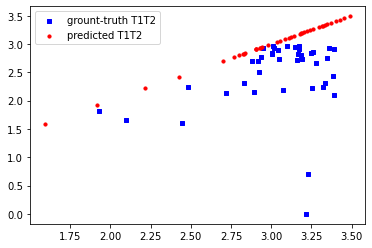

In [16]:
# Plot
 
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(T1T2[:,0], T1T2[:,1], s=10, c='b', marker="s", label='grount-truth T1T2')
ax1.scatter(T1T2_hat[:,0], T1T2_hat[:,1], s=10, c='r', marker="o", label='predicted T1T2')
plt.legend(loc='upper left');
plt.show()

# Figure: img

In [26]:
dataset = PingImgDataset_real()
x = dataset.D
y = dataset.labels
print(x.shape)

batch = (x.cuda(), y.cuda())
x, y = batch
print(y.shape)
T1T2 = y[:,0,1:3]
T1T2

# Forward
T1T2_hat, T1T2, loss = model.step_en_for_jupyter(batch, 0)
print(T1T2_hat.shape, T1T2.shape, loss)
T1T2_hat = T1T2_hat.detach().cpu(); T1T2 = T1T2.detach().cpu()

torch.Size([16384, 1, 1000])
torch.Size([7499, 1, 1000])
torch.Size([7499, 1000])
torch.Size([7499, 1000, 5])
torch.Size([7499, 2]) torch.Size([7499, 2]) tensor(0.0485, device='cuda:0', grad_fn=<MseLossBackward0>)


### Does reshape undo the flatten?

In [27]:
MRFData = scipy.io.loadmat("/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/MRI_N128_L1000_TE10.mat")


print(MRFData["T1_128"].shape)
# plt.imshow(MRFData["T1_128"])

# Flatten
T1 = torch.flatten(torch.from_numpy(MRFData["T1_128"]), 0, 1)
T1 = T1.unsqueeze(1).repeat(1, 100).unsqueeze(1)
T2 = torch.flatten(torch.from_numpy(MRFData["T2_128"]), 0, 1)
T2 = T2.unsqueeze(1).repeat(1, 100).unsqueeze(1)
print(T1.shape)

# Log
## Replace -inf with -100
T1_log = torch.nan_to_num(torch.log10(T1), neginf=-100)
T2_log = torch.nan_to_num(torch.log10(T2), neginf=-100)

## Get index that the value is -100
T1_idx_n100 = torch.where(T1_log != -100)[0]
T2_idx_n100 = torch.where(T2_log != -100)[0]
T1T2_idx_n100 = np.intersect1d(T1_idx_n100, T2_idx_n100)

## Get rid of -100
T1 = T1_log[T1T2_idx_n100]
T2 = T2_log[T1T2_idx_n100]
print(T1T2_idx_n100.shape, T1.shape, '----')

# Concat
T1T2 = torch.cat((T1, T2), 1)
T1T2 = T1T2.transpose(0, 1)
print(T1T2.shape)

############################################### reflect ####################################
# T1
T1 = T1T2[0, :, 0]
print(T1.shape)

# Reshape
T1= T1.reshape(128, -1)

# Undo Log
T1 = torch.exp(T1)


print(T1.shape)
plt.imshow(T1)

(128, 128)
torch.Size([16384, 1, 100])
(7499,) torch.Size([7499, 1, 100]) ----
torch.Size([2, 7499, 100])
torch.Size([7499])


RuntimeError: shape '[128, -1]' is invalid for input of size 7499

In [23]:

# Holder
T1_h = torch.zeros((128,128)).flatten()
T2_h = torch.zeros((128,128)).flatten()
T1_h[dataset.T1T2_idx_n100] = T1T2[:,0]
T2_h[dataset.T1T2_idx_n100] = T1T2[:,1]

T1_hat_h = torch.zeros((128,128)).flatten()
T2_hat_h = torch.zeros((128,128)).flatten()
T1_hat_h[dataset.T1T2_idx_n100] = T1T2_hat[:,0]
T2_hat_h[dataset.T1T2_idx_n100] = T1T2_hat[:,1]


# Change shape of T1T2 
T1_n = T1_h.view(128, 128)
T2_n = T2_h.view(128, 128)

T1_hat_n = T1_hat_h.view(128, 128)
T2_hat_n = T2_hat_h.view(128, 128)

error1_n = T1_n - T1_hat_n
error2_n = T2_n - T2_hat_n

print(T1.shape, T1_n.shape, T1_hat_n.shape, error1_n.shape)

# Undo the log
T1_n = torch.exp(T1_n); T2_n = torch.exp(T2_n)
T1_hat_n = torch.exp(T1_hat_n); T2_hat_n = torch.exp(T2_hat_n)
error1_n = torch.exp(error1_n); error2_n = torch.exp(error2_n)


sp=0
vari = ['T1_ground_truth','T1_hat', 'T2_ground_truth','T2_hat', 'error_T1', 'error_T2']
parm = [T1_n, T1_hat_n, T2_n, T2_hat_n, error1_n, error2_n]

plt.figure(figsize = (10,10))

for i in range(0, 3):
    plt.subplot(3, 2, sp+1)
    plt.imshow((parm[sp]).real)
    plt.title(vari[sp])
    sp += 1
    
    plt.subplot(3, 2, sp+1)
    plt.imshow((parm[sp]).real)
    plt.title(vari[sp])
    sp += 1

RuntimeError: shape mismatch: value tensor of shape [2, 100] cannot be broadcast to indexing result of shape [7499]

# Figure: line

In [37]:
test_data_type = 'real'

data_module = MRIDataModule(
            batch_size=128*128, num_workers=4, train_data_type="seqTr", test_data_type=test_data_type, subsamp=1, seq_jump=5, is_input_RF=1,
            need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True,
        )
data_module.prepare_data()
data_module.setup()
train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()
batch = next(iter(train_loader))
batch_test = next(iter(test_loader))

x, y = batch
bath = [x.cuda(), y.cuda()]
x, y = batch
T1T2 = y[:,0,1:3]
T1T2

# Forward
T1T2_hat, T1T2, loss = model.step_en_for_jupyter(batch, 0)
print(T1T2_hat.shape, T1T2.shape, loss)
T1T2_hat = T1T2_hat.detach().cpu(); T1T2 = T1T2.detach().cpu()



torch.Size([16384, 2]) torch.Size([16384, 2]) tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


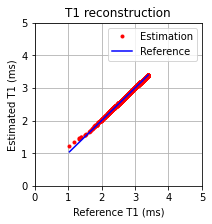

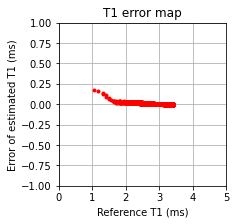

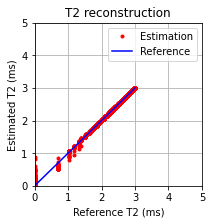

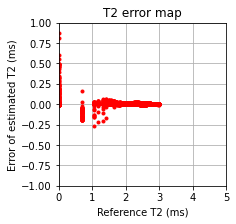

In [65]:
# show reconstruction

ind_T1 = np.argsort(T1T2[:,0])
Label_T1 = T1T2[ind_T1,0]
predictions_T1 = T1T2_hat[ind_T1,0]

ind_T2 = np.argsort(T1T2[:,1])
Label_T2 = T1T2[ind_T2,1]
predictions_T2 = T1T2_hat[ind_T2,1]


# Plot
mycmap = 'jet' # 'gray'
mydpi = 200

FigNameT1 = "T1_CNN_1Dsimu.png"
FigNameT2 = "T2_CNN_1Dsimu.png"
FigNameT1res = "T1_res_CNN_1Dsimu.png"
FigNameT2res = "T2_res_CNN_1Dsimu.png"
FigNameT1corr = "T1_corr_CNN_1Dsimu.png"
FigNameT2corr = "T2_corr_CNN_1Dsimu.png"
FigNameT1error = "T1_error_CNN_1Dsimu.png"
FigNameT2error = "T2_error_CNN_1Dsimu.png"

plt.figure(figsize = (3,3))

plt.plot(Label_T1, predictions_T1,'r.',label='Estimation')
plt.plot(Label_T1, Label_T1,'b-',label='Reference')
#plt.title('T1_Corr')
plt.grid(True)
plt.xlim((0, 5))
plt.ylim((0, 5))
plt.xlabel('Reference T1 (ms)')
plt.ylabel('Estimated T1 (ms)')
plt.legend(loc='best')
plt.title('T1 reconstruction')
plt.savefig(FigNameT1corr,bbox_inches='tight',transparent = True,pad_inches = 0,dpi=mydpi)
plt.show()

# show error maps
# plt.subplot(2,2,3)
plt.figure(figsize = (3,3))
plt.plot(Label_T1, predictions_T1-Label_T1,'r.',label='Estimation')
plt.grid(True)
plt.xlim((0, 5))
plt.ylim((-1, 1))
plt.xlabel('Reference T1 (ms)')
plt.ylabel('Error of estimated T1 (ms)')
plt.title('T1 error map')
#plt.legend(loc='best')
plt.savefig(FigNameT1error,bbox_inches='tight',transparent = True,pad_inches = 0,dpi=mydpi)
plt.show()

# plt.subplot(2,2,2)
plt.figure(figsize = (3,3))
plt.plot(Label_T2, predictions_T2,'r.',label='Estimation')
plt.plot(Label_T2, Label_T2,'b-',label='Reference')
#plt.title('T2_Corr')
plt.grid(True)
plt.xlim((0, 5))
plt.ylim((0, 5))
plt.xlabel('Reference T2 (ms)')
plt.ylabel('Estimated T2 (ms)')
plt.legend(loc='best')
plt.title('T2 reconstruction')
plt.savefig(FigNameT2corr,bbox_inches='tight',transparent = True,pad_inches = 0,dpi=mydpi)
plt.show()


# show error maps
# plt.subplot(2,2,4)
plt.figure(figsize = (3,3))
plt.plot(Label_T2, predictions_T2-Label_T2,'r.',label='Estimation')
plt.grid(True)
plt.xlim((0, 5))
plt.ylim((-1, 1))
plt.xlabel('Reference T2 (ms)')
plt.ylabel('Error of estimated T2 (ms)')
#plt.legend(loc='best')
plt.title('T2 error map')
plt.savefig(FigNameT2error,bbox_inches='tight',transparent = True,pad_inches = 0,dpi=mydpi)
plt.show()